# Yelp API - Lab


## Introduction 

Now that we've seen how the Yelp API works and some basic Folium visualizations, it's time to put those skills to work in order to create a working map! Taking things a step further, you'll also independently explore how to perform pagination in order to retrieve a full results set from the Yelp API!

## Objectives

You will be able to: 
* Create HTTP requests to get data from Yelp API
* Parse HTTP responses and perform data analysis on the data returned
* Perform pagination to retrieve troves of data!
* Create a simple geographical system to view information about selected businesses, at a given location. 

## Problem Introduction

You've now worked with some API calls, but we have yet to see how to retrieve a more complete dataset in a programmatic manner. Returning to the Yelp API, the [documentation](https://www.yelp.com/developers/documentation/v3/business_search) also provides us details regarding the API limits. These often include details about the number of requests a user is allowed to make within a specified time limit and the maximum number of results to be returned. In this case, we are told that any request has a maximum of 50 results per request and defaults to 20. Furthermore, any search will be limited to a total of 1000 results. To retrieve all 1000 of these results, we would have to page through the results piece by piece, retrieving 50 at a time. Processes such as these are often referred to as pagination.

In this lab, you will define a search and then paginate over the results to retrieve all of the results. You'll then parse these responses as a DataFrame (for further exploration) and create a map using Folium to visualize the results geographically.

## Part I - Make the Initial Request

Start by making an initial request to the Yelp API. Your search must include at least 2 parameters: **term** and **location**. For example, you might search for pizza restaurants in NYC. The term and location is up to you but make the request below.

In [1]:
# Your code here
import json

def get_keys(path):
    with open(path) as f:
        return json.load(f)
    
keys = get_keys("/home/khan/.secret/yelp_api.json")
api_key=keys['api_key']

import requests

term = 'halal'
location = 'Houston TX'

url = 'https://api.yelp.com/v3/businesses/search'

headers = {
        'Authorization': 'Bearer {}'.format(api_key),
    }

url_params = {
                'term': term.replace(' ', '+'),
                'location': location.replace(' ', '+')
            }
response = requests.get(url, headers=headers, params=url_params)
print(response)
print(type(response.text))
print(response.text[:1000])

<Response [200]>
<class 'str'>
{"businesses": [{"id": "A7SrbEPq1I_Pkf7wJlh_6w", "alias": "the-halal-guys-houston-9", "name": "The Halal Guys", "image_url": "https://s3-media1.fl.yelpcdn.com/bphoto/XJ8gUIG-8wLnOGWZdu2dSA/o.jpg", "is_closed": false, "url": "https://www.yelp.com/biz/the-halal-guys-houston-9?adjust_creative=xyRSKVfMLICySK6fG_LefQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=xyRSKVfMLICySK6fG_LefQ", "review_count": 1054, "categories": [{"alias": "mideastern", "title": "Middle Eastern"}, {"alias": "halal", "title": "Halal"}, {"alias": "mediterranean", "title": "Mediterranean"}], "rating": 4.0, "coordinates": {"latitude": 29.7322665, "longitude": -95.4121366}, "transactions": ["delivery", "pickup"], "price": "$", "location": {"address1": "3821 Farnham St", "address2": null, "address3": "", "city": "Houston", "zip_code": "77098", "country": "US", "state": "TX", "display_address": ["3821 Farnham St", "Houston, TX 77098"]}, "phone": "+17136815465", "disp

## Pagination

Now that you have an initial response, you can examine the contents of the JSON container. For example, you might start with ```response.json().keys()```. Here, you'll see a key for `'total'`, which tells you the full number of matching results given your query parameters. Write a loop (or ideally a function) which then makes successive API calls using the offset parameter to retrieve all of the results (or 5000 for a particularly large result set) for the original query. As you do this, be mindful of how you store the data. Your final goal will be to reformat the data concerning the businesses themselves into a pandas DataFrame from the json objects.

**Note: be mindful of the API rate limits. You can only make 5000 requests per day and are also can make requests too fast. Start prototyping small before running a loop that could be faulty. You can also use time.sleep(n) to add delays. For more details see https://www.yelp.com/developers/documentation/v3/rate_limiting.**

In [10]:
# Your code here; use a function or loop to retrieve all the results from your original request

resp_dict = dict(response.json())
business = resp_dict['businesses']

import pprint as pp

print(resp_dict['total'])
print(len(business))
pp.pprint(business)


485
20
[{'alias': 'the-halal-guys-houston-9',
  'categories': [{'alias': 'mideastern', 'title': 'Middle Eastern'},
                 {'alias': 'halal', 'title': 'Halal'},
                 {'alias': 'mediterranean', 'title': 'Mediterranean'}],
  'coordinates': {'latitude': 29.7322665, 'longitude': -95.4121366},
  'display_phone': '(713) 681-5465',
  'distance': 6089.05922396916,
  'id': 'A7SrbEPq1I_Pkf7wJlh_6w',
  'image_url': 'https://s3-media1.fl.yelpcdn.com/bphoto/XJ8gUIG-8wLnOGWZdu2dSA/o.jpg',
  'is_closed': False,
  'location': {'address1': '3821 Farnham St',
               'address2': None,
               'address3': '',
               'city': 'Houston',
               'country': 'US',
               'display_address': ['3821 Farnham St', 'Houston, TX 77098'],
               'state': 'TX',
               'zip_code': '77098'},
  'name': 'The Halal Guys',
  'phone': '+17136815465',
  'price': '$',
  'rating': 4.0,
  'review_count': 1054,
  'transactions': ['delivery', 'pickup'],
  'u

In [37]:
import math
def pull_results(term,location,offset = 0, limit = 20):
    
    keys = get_keys("/home/khan/.secret/yelp_api.json")
    api_key=keys['api_key']
    url = 'https://api.yelp.com/v3/businesses/search'

    headers = {
            'Authorization': 'Bearer {}'.format(api_key),
        }

    url_params = {
                    'term': term.replace(' ', '+'),
                    'location': location.replace(' ', '+'),
                    'offset' : int(offset),
                    'limit' : limit
                }
    response = requests.get(url, headers=headers, params=url_params)
    
    return response

def pull_all_data(term,location,items_per_call):
    
    first_resp = pull_results(term,location)
    
    resp_dict = dict(first_resp.json())
    total = resp_dict['total']
    num_of_calls = (math.ceil(total/items_per_call)) + 1
    
    results = []
    offset = 0
    
    for i in range(1,num_of_calls):
        
        resp = pull_results(term,location,offset,items_per_call)
    
        resp_dict = dict(resp.json())
        businesses = resp_dict['businesses']
        
        results = results + businesses
        
        offset += items_per_call
    
    return results


    
    
    


In [38]:
halal_places = pull_all_data('halal','Houston TX',50)

In [35]:
pp.pprint(halal_places)

[{'alias': 'the-halal-guys-houston-9',
  'categories': [{'alias': 'mideastern', 'title': 'Middle Eastern'},
                 {'alias': 'halal', 'title': 'Halal'},
                 {'alias': 'mediterranean', 'title': 'Mediterranean'}],
  'coordinates': {'latitude': 29.7322665, 'longitude': -95.4121366},
  'display_phone': '(713) 681-5465',
  'distance': 6089.05922396916,
  'id': 'A7SrbEPq1I_Pkf7wJlh_6w',
  'image_url': 'https://s3-media1.fl.yelpcdn.com/bphoto/XJ8gUIG-8wLnOGWZdu2dSA/o.jpg',
  'is_closed': False,
  'location': {'address1': '3821 Farnham St',
               'address2': None,
               'address3': '',
               'city': 'Houston',
               'country': 'US',
               'display_address': ['3821 Farnham St', 'Houston, TX 77098'],
               'state': 'TX',
               'zip_code': '77098'},
  'name': 'The Halal Guys',
  'phone': '+17136815465',
  'price': '$',
  'rating': 4.0,
  'review_count': 1054,
  'transactions': ['pickup', 'delivery'],
  'url': 'h

               'city': 'Houston',
               'country': 'US',
               'display_address': ['912 Westheimer St', 'Houston, TX 77006'],
               'state': 'TX',
               'zip_code': '77006'},
  'name': 'Aladdin Mediterranean Cuisine',
  'phone': '+17139422321',
  'price': '$$',
  'rating': 4.5,
  'review_count': 1033,
  'transactions': [],
  'url': 'https://www.yelp.com/biz/aladdin-mediterranean-cuisine-houston?adjust_creative=xyRSKVfMLICySK6fG_LefQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=xyRSKVfMLICySK6fG_LefQ'},
 {'alias': 'smoked-n-chopped-catering-stafford',
  'categories': [{'alias': 'bbq', 'title': 'Barbeque'},
                 {'alias': 'catering', 'title': 'Caterers'},
                 {'alias': 'halal', 'title': 'Halal'}],
  'coordinates': {'latitude': 29.61401, 'longitude': -95.58208},
  'display_phone': '',
  'distance': 27043.920318382112,
  'id': '025OvpEuU1VNZXdVO2AdaA',
  'image_url': 'https://s3-media1.fl.yelpcdn.com/bpho

  'location': {'address1': '6802 Bintliff Dr',
               'address2': '',
               'address3': None,
               'city': 'Houston',
               'country': 'US',
               'display_address': ['6802 Bintliff Dr', 'Houston, TX 77074'],
               'state': 'TX',
               'zip_code': '77074'},
  'name': 'Cafe Habibi',
  'phone': '+18323666645',
  'price': '$$',
  'rating': 4.5,
  'review_count': 14,
  'transactions': [],
  'url': 'https://www.yelp.com/biz/cafe-habibi-houston?adjust_creative=xyRSKVfMLICySK6fG_LefQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=xyRSKVfMLICySK6fG_LefQ'},
 {'alias': 'taste-of-nigeria-houston',
  'categories': [{'alias': 'african', 'title': 'African'}],
  'coordinates': {'latitude': 29.73088, 'longitude': -95.48389},
  'display_phone': '(713) 589-9055',
  'distance': 12474.558128853625,
  'id': 'TDOR12yJyUWKYeRm-9Prqg',
  'image_url': 'https://s3-media3.fl.yelpcdn.com/bphoto/MzlL1VffLYeU3OJn9aNrjg/o.jpg',
  '

               'state': 'TX',
               'zip_code': '77057'},
  'name': 'Mr. Kabab',
  'phone': '+18328002254',
  'price': '$',
  'rating': 3.5,
  'review_count': 7,
  'transactions': [],
  'url': 'https://www.yelp.com/biz/mr-kabab-houston-4?adjust_creative=xyRSKVfMLICySK6fG_LefQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=xyRSKVfMLICySK6fG_LefQ'},
 {'alias': 'deens-houston-2',
  'categories': [{'alias': 'cheesesteaks', 'title': 'Cheesesteaks'},
                 {'alias': 'pizza', 'title': 'Pizza'},
                 {'alias': 'icecream', 'title': 'Ice Cream & Frozen Yogurt'}],
  'coordinates': {'latitude': 29.84959, 'longitude': -95.6826},
  'display_phone': '(832) 683-4714',
  'distance': 32598.995756372813,
  'id': 'Ca6LlG85CB_UX-ipnc7jxg',
  'image_url': 'https://s3-media2.fl.yelpcdn.com/bphoto/rUNcdcpn1b-rJGmwa8jG_g/o.jpg',
  'is_closed': False,
  'location': {'address1': '5222 Barker Cypress Rd',
               'address2': '',
               'address

               'address3': '',
               'city': 'Porter',
               'country': 'US',
               'display_address': ['24141 Highway 59 N', 'Porter, TX 77365'],
               'state': 'TX',
               'zip_code': '77365'},
  'name': 'L&H Cafe',
  'phone': '+12817477741',
  'price': '$$',
  'rating': 5.0,
  'review_count': 5,
  'transactions': ['pickup', 'delivery'],
  'url': 'https://www.yelp.com/biz/l-and-h-cafe-porter?adjust_creative=xyRSKVfMLICySK6fG_LefQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=xyRSKVfMLICySK6fG_LefQ'},
 {'alias': 'al-ameen-grocery-and-halal-meat-market-houston',
  'categories': [{'alias': 'meats', 'title': 'Meat Shops'},
                 {'alias': 'intlgrocery', 'title': 'International Grocery'},
                 {'alias': 'importedfood', 'title': 'Imported Food'}],
  'coordinates': {'latitude': 29.6841, 'longitude': -95.39154},
  'display_phone': '(713) 842-6192',
  'distance': 9187.317408695904,
  'id': '-4V9y-eElVA

  'transactions': [],
  'url': 'https://www.yelp.com/biz/tonys-pizza-and-grinders-houston?adjust_creative=xyRSKVfMLICySK6fG_LefQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=xyRSKVfMLICySK6fG_LefQ'},
 {'alias': 'space-city-pizza-webster',
  'categories': [{'alias': 'pizza', 'title': 'Pizza'}],
  'coordinates': {'latitude': 29.5586413712152, 'longitude': -95.1465408504009},
  'display_phone': '(281) 954-6773',
  'distance': 30687.488197555293,
  'id': '0CsvGHyGs0TsfMBfd6tS9A',
  'image_url': 'https://s3-media4.fl.yelpcdn.com/bphoto/r9sdWp9xYkXbQYzhDhDjJw/o.jpg',
  'is_closed': False,
  'location': {'address1': '435 El Dorado Blvd',
               'address2': '',
               'address3': None,
               'city': 'Webster',
               'country': 'US',
               'display_address': ['435 El Dorado Blvd', 'Webster, TX 77598'],
               'state': 'TX',
               'zip_code': '77598'},
  'name': 'Space City Pizza',
  'phone': '+12819546773',
  '

               'address2': 'Ste 100',
               'address3': '',
               'city': 'Houston',
               'country': 'US',
               'display_address': ['3939 Hilcroft Ave',
                                   'Ste 100',
                                   'Houston, TX 77057'],
               'state': 'TX',
               'zip_code': '77057'},
  'name': "Abdallah's Bakery",
  'phone': '+17139524747',
  'price': '$$',
  'rating': 4.0,
  'review_count': 145,
  'transactions': ['pickup', 'delivery'],
  'url': 'https://www.yelp.com/biz/abdallahs-bakery-houston?adjust_creative=xyRSKVfMLICySK6fG_LefQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=xyRSKVfMLICySK6fG_LefQ'},
 {'alias': 'almadina-supermarket-houston',
  'categories': [{'alias': 'meats', 'title': 'Meat Shops'},
                 {'alias': 'intlgrocery', 'title': 'International Grocery'},
                 {'alias': 'halal', 'title': 'Halal'}],
  'coordinates': {'latitude': 29.73096, 'longitude'

               'zip_code': '77006'},
  'name': 'Al Quick Stop',
  'phone': '+17135225170',
  'price': '$',
  'rating': 4.5,
  'review_count': 246,
  'transactions': ['delivery', 'pickup'],
  'url': 'https://www.yelp.com/biz/al-quick-stop-houston?adjust_creative=xyRSKVfMLICySK6fG_LefQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=xyRSKVfMLICySK6fG_LefQ'},
 {'alias': 'fresh-choice-cafe-houston',
  'categories': [{'alias': 'breakfast_brunch', 'title': 'Breakfast & Brunch'},
                 {'alias': 'juicebars', 'title': 'Juice Bars & Smoothies'},
                 {'alias': 'mediterranean', 'title': 'Mediterranean'}],
  'coordinates': {'latitude': 29.747445, 'longitude': -95.45753},
  'display_phone': '(713) 622-3333',
  'distance': 9577.338305093246,
  'id': '_ezIBfs2SuxBDjqQKd-dDA',
  'image_url': 'https://s3-media2.fl.yelpcdn.com/bphoto/VwR78vaSPJ0wf64FV2vCDw/o.jpg',
  'is_closed': False,
  'location': {'address1': '1900 West Loop S',
               'address2':

               'state': 'TX',
               'zip_code': '77479'},
  'name': 'Shahi Darbar',
  'phone': '+18325320532',
  'rating': 3.5,
  'review_count': 22,
  'transactions': ['pickup', 'delivery'],
  'url': 'https://www.yelp.com/biz/shahi-darbar-sugar-land?adjust_creative=xyRSKVfMLICySK6fG_LefQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=xyRSKVfMLICySK6fG_LefQ'},
 {'alias': 'the-simple-greek-pearland',
  'categories': [{'alias': 'greek', 'title': 'Greek'}],
  'coordinates': {'latitude': 29.556593, 'longitude': -95.38534},
  'display_phone': '(346) 340-4976',
  'distance': 23086.91479967135,
  'id': 'rY2XmEGbg3X8o_KTneIxyQ',
  'image_url': 'https://s3-media3.fl.yelpcdn.com/bphoto/7K5viqO9hoyElizOzL4uaw/o.jpg',
  'is_closed': False,
  'location': {'address1': '10621 Broadway St',
               'address2': 'Ste 109',
               'address3': None,
               'city': 'Pearland',
               'country': 'US',
               'display_address': ['10621 Br

  'rating': 3.5,
  'review_count': 6,
  'transactions': [],
  'url': 'https://www.yelp.com/biz/cabritos-garza-meat-processing-and-taqueria-humble-2?adjust_creative=xyRSKVfMLICySK6fG_LefQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=xyRSKVfMLICySK6fG_LefQ'},
 {'alias': 'malt-n-burger-alvin-2',
  'categories': [{'alias': 'hotdog', 'title': 'Hot Dogs'},
                 {'alias': 'burgers', 'title': 'Burgers'},
                 {'alias': 'sandwiches', 'title': 'Sandwiches'}],
  'coordinates': {'latitude': 29.437935, 'longitude': -95.270749},
  'display_phone': '(281) 331-7955',
  'distance': 37136.03764058022,
  'id': '6aMXqI_JwJdnXV-oUaeWsA',
  'image_url': 'https://s3-media3.fl.yelpcdn.com/bphoto/qOQAAzC-EHodooBISqEnRw/o.jpg',
  'is_closed': False,
  'location': {'address1': '25330 W Hwy 6',
               'address2': None,
               'address3': None,
               'city': 'Alvin',
               'country': 'US',
               'display_address': ['25330 W

  'transactions': ['pickup', 'delivery'],
  'url': 'https://www.yelp.com/biz/aji-ramen-katy?adjust_creative=xyRSKVfMLICySK6fG_LefQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=xyRSKVfMLICySK6fG_LefQ'},
 {'alias': 'the-haleem-bowl-sugarland',
  'categories': [{'alias': 'foodtrucks', 'title': 'Food Trucks'},
                 {'alias': 'catering', 'title': 'Caterers'}],
  'coordinates': {'latitude': 29.6439985, 'longitude': -95.6520803},
  'display_phone': '(832) 788-0422',
  'distance': 31164.63970327243,
  'id': 'Z2r7h_g0o3Ki2thNFcFFow',
  'image_url': 'https://s3-media1.fl.yelpcdn.com/bphoto/0-Hmn74dPbLqnJf6YGn23w/o.jpg',
  'is_closed': False,
  'location': {'address1': '11836 S Highway 6',
               'address2': None,
               'address3': None,
               'city': 'Sugarland',
               'country': 'US',
               'display_address': ['11836 S Highway 6', 'Sugarland, TX 77498'],
               'state': 'TX',
               'zip_code': '774

  'rating': 3.5,
  'review_count': 14,
  'transactions': ['delivery', 'pickup'],
  'url': 'https://www.yelp.com/biz/tempura-kabob-grill-and-more-houston?adjust_creative=xyRSKVfMLICySK6fG_LefQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=xyRSKVfMLICySK6fG_LefQ'},
 {'alias': 'burgerim-humble-2',
  'categories': [{'alias': 'tradamerican', 'title': 'American (Traditional)'},
                 {'alias': 'burgers', 'title': 'Burgers'},
                 {'alias': 'chicken_wings', 'title': 'Chicken Wings'}],
  'coordinates': {'latitude': 30.019449, 'longitude': -95.268769},
  'display_phone': '(832) 644-8597',
  'distance': 29837.255392893225,
  'id': 'pL4d-se_kzes2eMJzrmI3A',
  'image_url': 'https://s3-media2.fl.yelpcdn.com/bphoto/1Yfn7wNyVYf7WEWcC9WY3Q/o.jpg',
  'is_closed': False,
  'location': {'address1': '20845 Hwy 59 N',
               'address2': 'Ste 200',
               'address3': None,
               'city': 'Humble',
               'country': 'US',
        

               'city': 'Spring',
               'country': 'US',
               'display_address': ['1650 Louetta Rd',
                                   'Ste 500',
                                   'Spring, TX 77388'],
               'state': 'TX',
               'zip_code': '77388'},
  'name': 'Burgerim',
  'phone': '+18326639991',
  'price': '$$',
  'rating': 4.0,
  'review_count': 61,
  'transactions': [],
  'url': 'https://www.yelp.com/biz/burgerim-spring-3?adjust_creative=xyRSKVfMLICySK6fG_LefQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=xyRSKVfMLICySK6fG_LefQ'},
 {'alias': 'bismillah-grocers-and-halal-meat-webster',
  'categories': [{'alias': 'grocery', 'title': 'Grocery'},
                 {'alias': 'meats', 'title': 'Meat Shops'}],
  'coordinates': {'latitude': 29.5682922, 'longitude': -95.1468758},
  'display_phone': '(281) 286-2929',
  'distance': 29824.99755571443,
  'id': 'SKkPP2NXAF3po3mqUfXt_Q',
  'image_url': '',
  'is_closed': False,
  'locat

               'state': 'TX',
               'zip_code': '77429'},
  'name': 'Nara Thai Dining',
  'phone': '+12817581222',
  'rating': 3.5,
  'review_count': 23,
  'transactions': ['delivery', 'pickup'],
  'url': 'https://www.yelp.com/biz/nara-thai-dining-cypress?adjust_creative=xyRSKVfMLICySK6fG_LefQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=xyRSKVfMLICySK6fG_LefQ'},
 {'alias': 'world-food-warehouse-houston',
  'categories': [{'alias': 'grocery', 'title': 'Grocery'},
                 {'alias': 'importedfood', 'title': 'Imported Food'}],
  'coordinates': {'latitude': 29.688562, 'longitude': -95.646482},
  'display_phone': '(281) 988-4585',
  'distance': 28880.15513195984,
  'id': 'psoPerOFNI0GyLE8yB5_8w',
  'image_url': 'https://s3-media4.fl.yelpcdn.com/bphoto/vGDAozgb7ECcEIb8rn3RfQ/o.jpg',
  'is_closed': False,
  'location': {'address1': '14625 Beechnut St',
               'address2': '',
               'address3': '',
               'city': 'Houston',
   

In [39]:
print(len(halal_places))

485


## Exploratory Analysis

Take the restaurants from the previous question and do an initial exploratory analysis. At minimum, this should include looking at the distribution of features such as price, rating and number of reviews as well as the relations between these dimensions.

In [52]:
# Your code here

import pandas as pd

df = pd.DataFrame(halal_places)
display(df.head())

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,distance
0,A7SrbEPq1I_Pkf7wJlh_6w,the-halal-guys-houston-9,The Halal Guys,https://s3-media1.fl.yelpcdn.com/bphoto/XJ8gUI...,False,https://www.yelp.com/biz/the-halal-guys-housto...,1054,"[{'alias': 'mideastern', 'title': 'Middle East...",4.0,"{'latitude': 29.7322665, 'longitude': -95.4121...","[delivery, pickup]",$,"{'address1': '3821 Farnham St', 'address2': No...",+17136815465,(713) 681-5465,6089.059224
1,KsvNPaZ43EmQgP6iXzOu_Q,burganic-hub-houston-3,Burganic Hub,https://s3-media2.fl.yelpcdn.com/bphoto/FDzAXw...,False,https://www.yelp.com/biz/burganic-hub-houston-...,93,"[{'alias': 'burgers', 'title': 'Burgers'}, {'a...",4.5,"{'latitude': 29.73733533, 'longitude': -95.476...","[delivery, pickup]",$,"{'address1': '2721 Chimney Rock Rd', 'address2...",+18328344930,(832) 834-4930,11582.964841
2,Y_alysR9cw4RZsOip0cQbw,mico-s-hot-chicken-houston,Mico’s Hot Chicken,https://s3-media4.fl.yelpcdn.com/bphoto/rXh34s...,False,https://www.yelp.com/biz/mico-s-hot-chicken-ho...,219,"[{'alias': 'chickenshop', 'title': 'Chicken Sh...",4.5,"{'latitude': 29.7364923677041, 'longitude': -9...",[],$,"{'address1': '2829 Chimney Rock Rd', 'address2...",+17135143924,(713) 514-3924,11600.884820
3,D3q6znHJhRMZhBbtGRl05Q,las-brasas-charcoal-chicken-houston-2,Las Brasas Charcoal Chicken,https://s3-media4.fl.yelpcdn.com/bphoto/8_spe0...,False,https://www.yelp.com/biz/las-brasas-charcoal-c...,176,"[{'alias': 'peruvian', 'title': 'Peruvian'}, {...",4.5,"{'latitude': 29.73268, 'longitude': -95.62425}","[delivery, pickup]",$$,"{'address1': '2712 Eldridge Pkwy', 'address2':...",+13467545185,(346) 754-5185,25751.525649
4,lY2rf6zMpwsgnD_YD_nxWQ,gyro-king-houston,Gyro King,https://s3-media3.fl.yelpcdn.com/bphoto/Ys4bIx...,False,https://www.yelp.com/biz/gyro-king-houston?adj...,705,"[{'alias': 'foodtrucks', 'title': 'Food Trucks...",4.5,"{'latitude': 29.698073, 'longitude': -95.387614}","[delivery, pickup]",$,"{'address1': '2424 Old Spanish Trl', 'address2...",+18326184891,(832) 618-4891,7700.374061


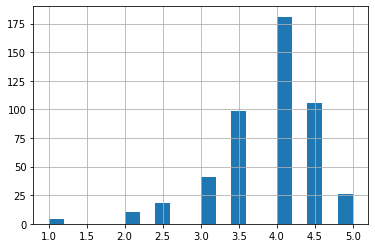

In [61]:
df['rating'].hist(bins=20);

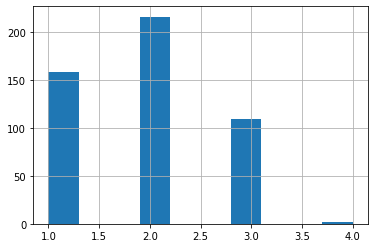

In [59]:
df['price_num']= df['price'].map(lambda x: len(str(x)))
df['price_num'].hist(bins=10);

In [71]:
print(df['review_count'].unique())

[1054   93  219  176  705   79  518  217  643   67   33  165  713  433
   28  231  224  659  175  263    2 1336   46    5  171   80 1093   17
   30  118   13    1   37  107 1033   20   49  291    8   54  149    3
  126   94  170  619   35  515   74  343   14  305  218  752   24  350
   26 1649   76   91   16    6   81  138 1047   12  966  103   10  249
   15  204  273   47  106  146  181   32  137 2174  250 2014  100  238
    7   70   44  133  186  482   62  200  101  266  112   60 1889  260
  597   53   59   63  145  420  185  114   29  111  247  649   18   23
  365  414   82  188  128   61  390  210   58  168  190  362  116   38
 4312  156  495   90  397  110  277  140  293  151   43  108  321 1091
  195  177  999 1237  201  143  774 1858   39   71  311  283 1026   92
   25   50   86  154  169  466  326  313  132  256  182   83  246    9
  271 1571  141   40  642  393 1272   99  159   22  909  123   41  139
   98  430  923  599   21   65   89   19  134   51  120   42  288  147
  316 

## Mapping

Look at the initial Yelp example and try and make a map using Folium of the restaurants you retrieved. Be sure to also add popups to the markers giving some basic information such as name, rating and price.

In [84]:
# Your code here
df['lat'] = df['coordinates'].map(lambda x: x['latitude'])
df['long'] = df['coordinates'].map(lambda x: x['longitude'])

lat = df['lat'].median()
long = df['long'].median()

import folium

base_map = folium.Map([lat,long],zoom_start = 11)

for index,row in df.iterrows():
    lat = row['lat']
    long = row['long']
    popup_text = row['name']
    popup = folium.Popup(popup_text,parse_html=True)
    marker = folium.Marker(location=[lat,long],popup=popup)
    marker.add_to(base_map)

base_map

## Summary

Nice work! In this lab, you synthesized your skills for the day, making multiple API calls to Yelp in order to paginate through a results set, performing some basic exploratory analysis and then creating a nice map visual to display the results! Well done!